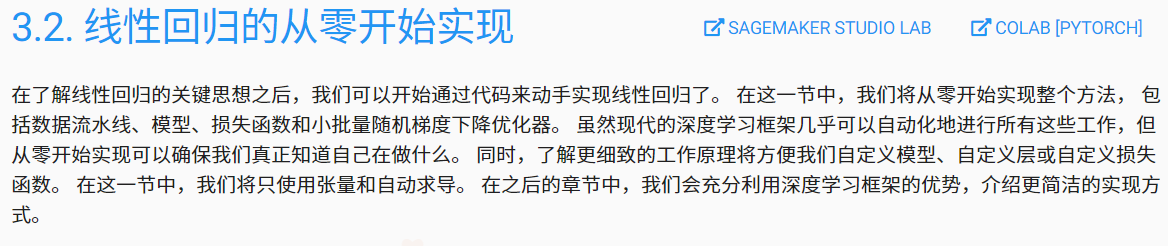

In [1]:
import sys

sys.path.append('../../../../')

%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 1. 生成数据集

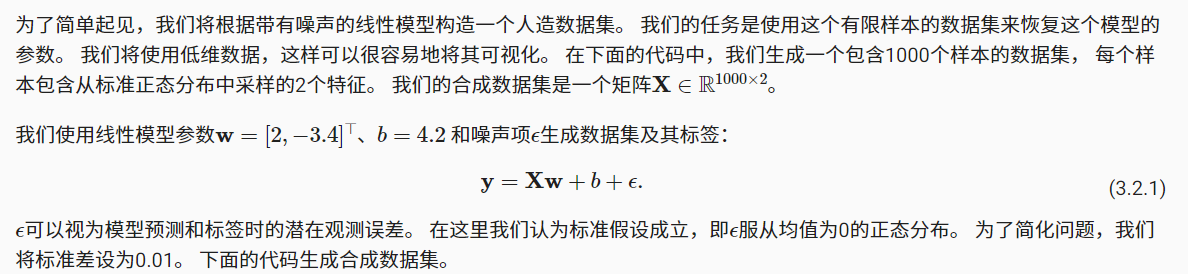

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）。

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.3281, -0.7346]) 
label: tensor([6.0380])


通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。

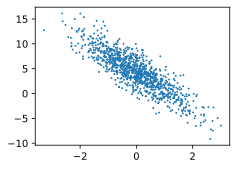

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

# 2. 读取数据集

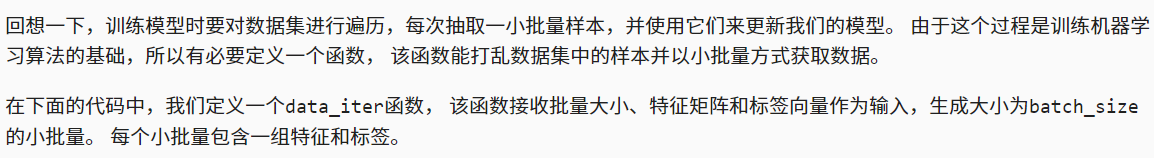

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

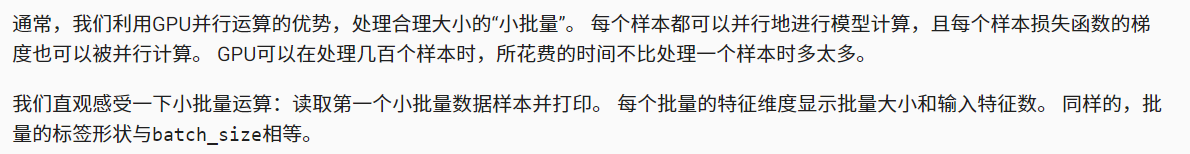

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.9032,  0.2782],
        [-0.9770, -2.1620],
        [ 0.0326,  0.5275],
        [ 2.0554,  1.3999],
        [ 0.8049, -1.5581],
        [ 1.0683,  1.5958],
        [ 1.2611, -0.7276],
        [ 1.2587,  0.3413],
        [ 0.7026, -2.6215],
        [ 0.7375, -0.6767]]) 
 tensor([[ 5.0562],
        [ 9.6026],
        [ 2.4470],
        [ 3.5407],
        [11.1114],
        [ 0.8973],
        [ 9.1898],
        [ 5.5444],
        [14.5334],
        [ 7.9703]])


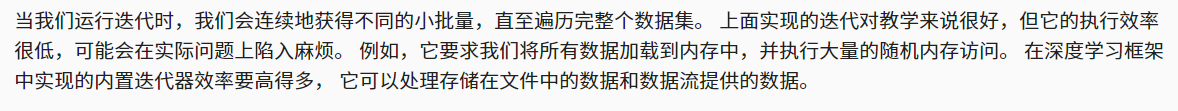

# 3. 初始化模型参数

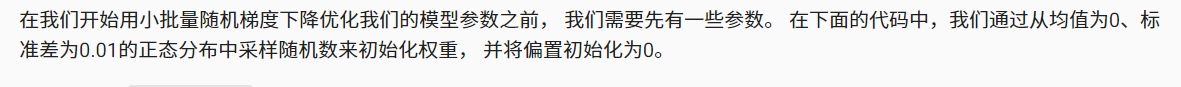

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

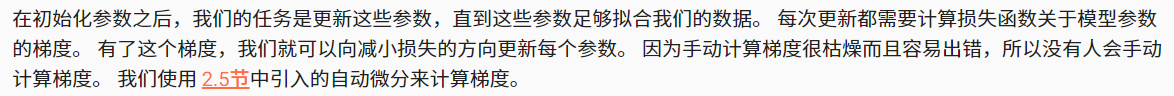

# 4. 定义模型

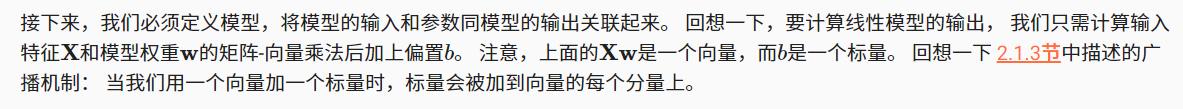

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

# 5. 定义损失函数

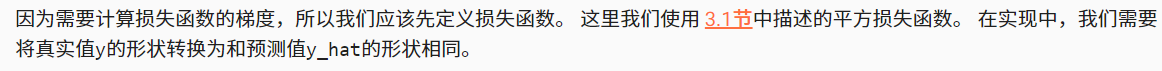

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 6. 定义优化算法

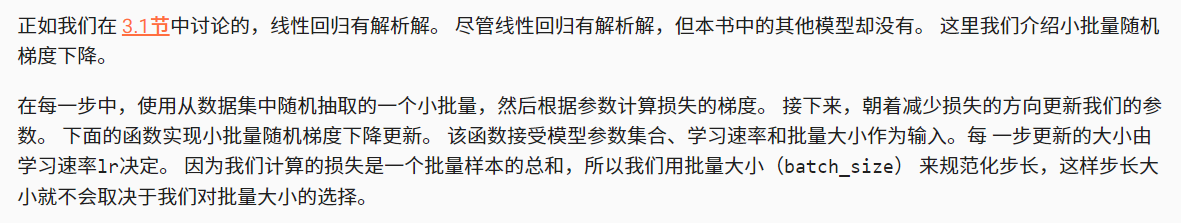

In [10]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 7. 训练

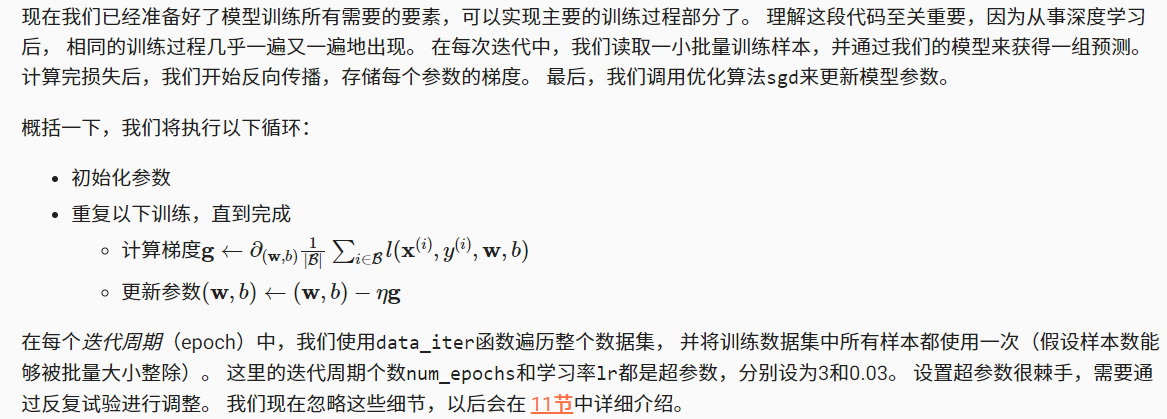

In [11]:
lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 2.190169
epoch 2, loss 0.286543
epoch 3, loss 0.037775
epoch 4, loss 0.005047
epoch 5, loss 0.000718
epoch 6, loss 0.000140
epoch 7, loss 0.000063
epoch 8, loss 0.000052
epoch 9, loss 0.000051
epoch 10, loss 0.000051


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。 事实上，真实参数和通过训练学到的参数确实非常接近

In [13]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-6.6137e-04, -9.0361e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([7.9155e-05], grad_fn=<RsubBackward1>)


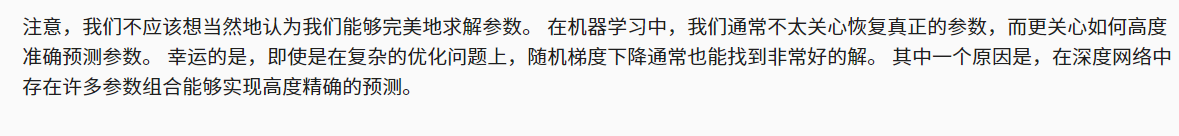

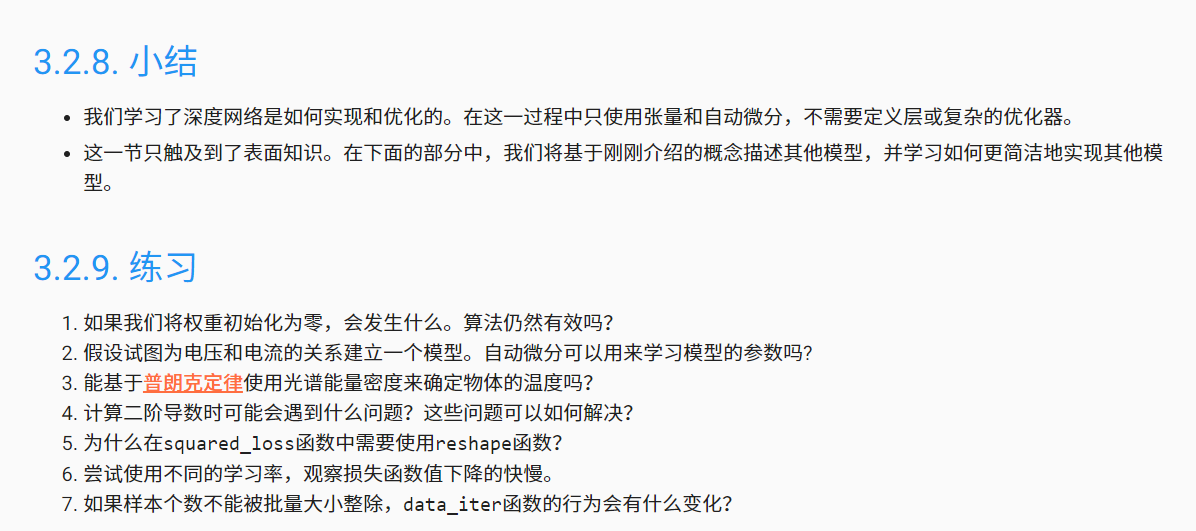